In [1]:
import numpy as np
import tensorflow as tf
from backend.networks import Model
import backend as be
from backend.simulation_tools import Simulator
from tasks import memory_tasks as mt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mem_gap_length = 100
# name = 'mem_sac_var_in_out_mem'

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'

# weights_path = './weights/mem_sac_fixed_100.npz'
weights_path = './weights/mem_sac_variable_75.npz'
    
#task params
input_wait = 40
stim_dur = 10
out_gap = 0
out_dur = 60

var_delay_length = 0
var_in_wait = 40
var_out_gap = 0
second_in_scale = 0.  #Only one input period or two (e.g. mem saccade no distractor vs with distractor)
task = 'memory_saccade'
name = 'mem_sac_fixed'

#model params
n_in = 2 
n_hidden = 100 
n_out = 2
#n_steps = 80 
tau = 100.0 #As double
dt = 20.0  #As double
dale_ratio = 0
rec_noise = 0.0
stim_noise = 0.1
batch_size = 128


#train params
learning_rate = .0001 
training_iters = 5000000
display_step = 200

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'
#weights_path = None

params = mt.set_params(epochs=200, sample_size= batch_size, input_wait=input_wait, 
                    stim_dur=stim_dur, mem_gap=mem_gap_length, out_gap = out_gap, out_dur=out_dur, 
                    N_rec=n_hidden, n_out = n_out, n_in = n_in, 
                    var_delay_length=var_delay_length,
                    var_in_wait = var_in_wait, var_out_gap = var_out_gap,
                    rec_noise=rec_noise, stim_noise=stim_noise, 
                    dale_ratio=dale_ratio, tau=tau, task=task,
                    second_in_scale=second_in_scale)

generator = mt.generate_train_trials(params)

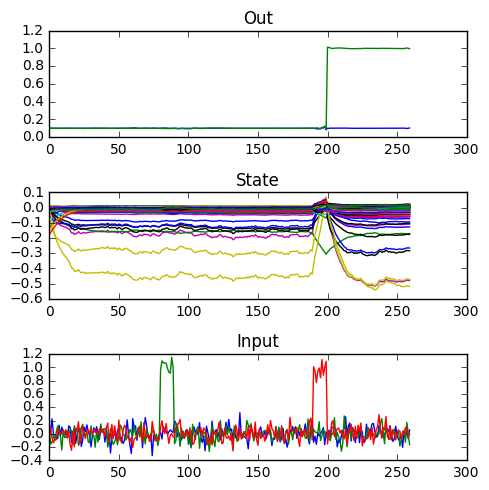

In [3]:


weights = np.load(weights_path)

W = weights['W_rec']
brec = weights['b_rec']

data = generator.next()

sim = Simulator(params, weights_path=weights_path)
output,states = sim.run_trial(data[0][0,:,:],t_connectivity=False)

plt.figure(figsize=(5,5))
plt.subplot(3,1,1)
plt.plot(output[:,0,:])
plt.title('Out')
plt.subplot(3,1,2)
plt.plot(states[:,0,:])
plt.title('State')
plt.subplot(3,1,3)
plt.plot(data[0][0,:,:])
plt.title('Input')

plt.tight_layout()
plt.show()

In [4]:
def plot_by_max(state,norm=True,thresh=.001):
    fr = np.maximum(state,thresh)
    if norm:
        fr = ((fr-np.mean(fr,axis=0))/np.std(fr,axis=0))
    idx = np.argsort(np.argmax(fr,axis=0))
    plt.pcolormesh(fr[:,idx].T)
    plt.colorbar()
    plt.xlim([0,np.shape(fr)[0]])
    
def plot_dist_to_fixed(state,fp):
    d = np.zeros(np.shape(state)[0])
    for ii in range(np.shape(state)[0]):
        d[ii] = np.sum((fp-state[ii,:])**2)
    plt.plot(d,'.')
    plt.ylim([0,np.max(d)*1.5])
    return d

def principal_angle(A,B):
    ''' A = n x p
        B = n x q'''
    
    Qa, ra = np.linalg.qr(A)
    Qb, rb = np.linalg.qr(B)
    C = np.linalg.svd(Qa.T.dot(Qb))
    angles = np.arccos(C[1])
    
    return 180*angles/np.pi

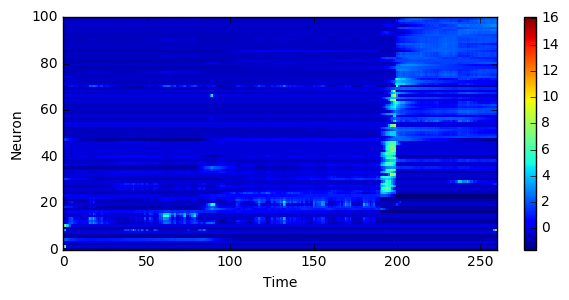

In [5]:

plt.figure(figsize=(7,3))
plot_by_max(states[:,0,:])
plt.xlabel('Time')
plt.ylabel('Neuron')

plt.show()

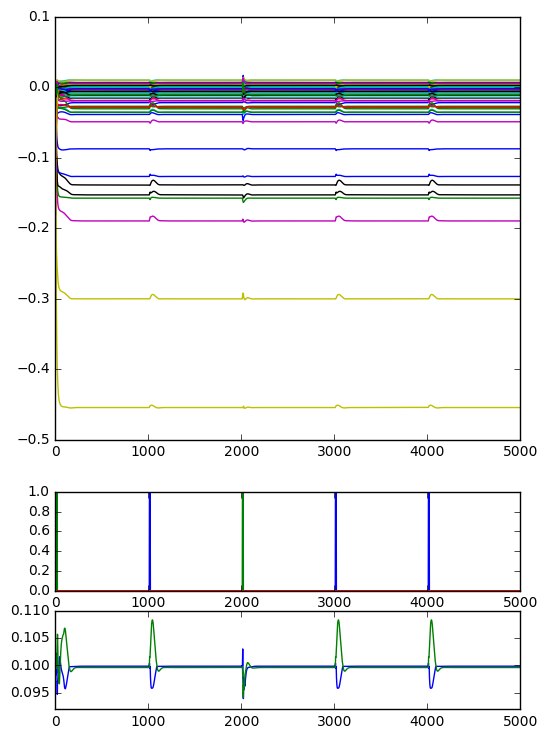

In [6]:
out0,s0,out1,s1 = mt.long_delay_test(sim)

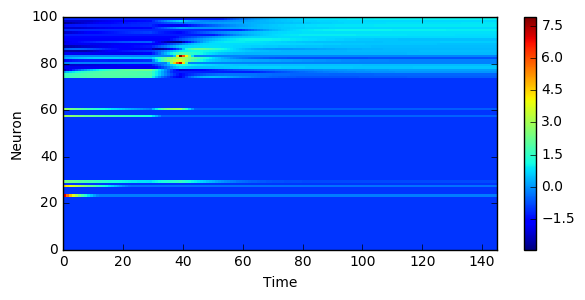

In [7]:
plt.figure(figsize=(7,3))
plot_by_max(s0[20:165,0,:])
plt.xlabel('Time')
plt.ylabel('Neuron')

plt.show()

In [8]:
fps0 = mt.fixed_point_analysis(s0[:,0,:],W,brec)
fps1 = mt.fixed_point_analysis(s1[:,0,:],W,brec)

(0, 0.01)

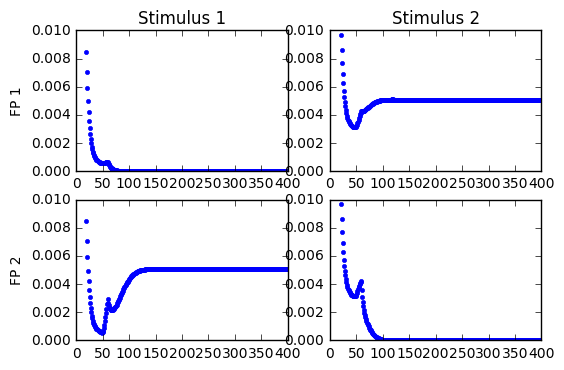

In [9]:
trial_length = data[0].shape[1]

trial_length = 400

plt.subplot(2,2,1)
d = plot_dist_to_fixed(s0[:trial_length,0,:],fps0[-1]['fp'])
plt.ylim([0,.01])
plt.title('Stimulus 1')
plt.ylabel('FP 1')
plt.subplot(2,2,2)
plt.title('Stimulus 2')
d = plot_dist_to_fixed(s0[:trial_length,0,:],fps1[-1]['fp'])
plt.ylim([0,.01])

plt.subplot(2,2,3)
d = plot_dist_to_fixed(s1[:trial_length,0,:],fps0[-1]['fp'])
plt.ylim([0,.01])
plt.ylabel('FP 2')
plt.subplot(2,2,4)
d = plot_dist_to_fixed(s1[:trial_length,0,:],fps1[-1]['fp'])
plt.ylim([0,.01])

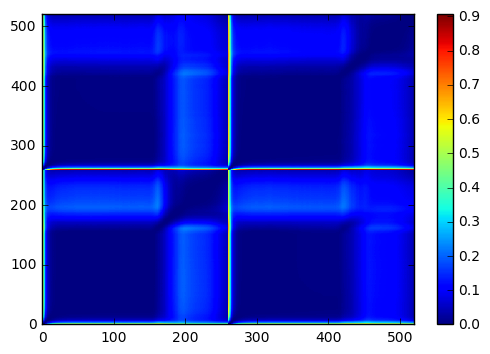

In [10]:
s = np.zeros([data[0].shape[1],data[0].shape[0],100])
for ii in range(data[0].shape[0]):
    s[:,ii,:] = sim.run_trial(data[0][ii,:,:],t_connectivity=False)[1].reshape([data[0].shape[1],100])
    
dirs = np.argmax(np.mean(data[1][:,180:200,:],axis=1),axis=1)
c_dirs = np.corrcoef(np.mean(s[:,dirs==0,:],axis=1),np.mean(s[:,dirs==1,:],axis=1))

plt.pcolormesh(1-c_dirs)
plt.colorbar()
plt.ylim([0,c_dirs.shape[0]])
plt.xlim([0,c_dirs.shape[0]])
plt.show()
# plt.pcolormesh(.5*c_dirs[200:,:200] + .5*c_dirs[:200,200:]);# - .5*c_dirs[200:,200:] - .5*c_dirs[:200,:200]), plt.colorbar();

/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in arccos


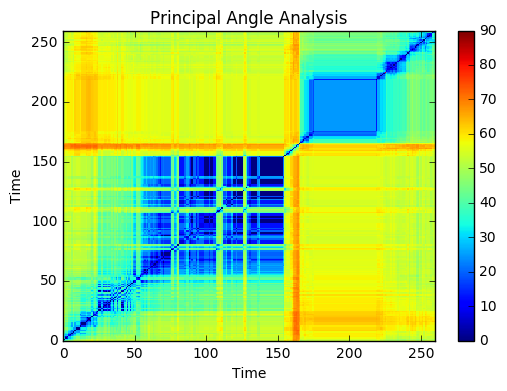

In [11]:

# masks = (np.mean(s,axis=1).T>0)
masks = s[:,2,:].T>0

# W = np.random.randn(100,100)
# dale = np.eye(100)
# dale[:,50] *= -1
# W = np.abs(W).dot(dale)

# W = 1.1*W/np.max(np.abs(np.linalg.eig(W)[0]))

max_ev = np.zeros(data[0].shape[1])

pos = []
neg = []
leading = []
for ii in range(data[0].shape[1]):
    evals,evecs = np.linalg.eig(W*masks[:,ii]-np.eye(100))
    max_ev[ii] = np.max(evals.real)
    pos.append(evecs[:,evals>0])
    neg.append(evecs[:,evals<0])
    leading.append(evecs[:,np.argsort(np.abs(evals.real))[:10]]) #.reshape([100,2]))
    

xx = np.arange(0,data[0].shape[1],1)
pa = np.zeros([len(xx),len(xx)])

basis = leading

for ii,pre in enumerate(xx):
    for jj,post in enumerate(xx):
        if basis[pre].shape[1]*basis[post].shape[1]>0:
            pas = principal_angle(basis[pre],basis[post])
            pa[ii,jj] = np.nanmean(pas)
        else:
            pa[ii,jj] = 0.
        
plt.pcolormesh(pa,vmin=0,vmax=90)
plt.colorbar()
plt.ylim([0,pa.shape[0]])
plt.xlim([0,pa.shape[1]])

plt.title('Principal Angle Analysis')
plt.xlabel('Time')
plt.ylabel('Time')
plt.show()
        

In [77]:
evals[np.argsort(np.abs(evals.real))[:10]]

array([-0.46907084+0.j        , -0.49608660-0.78900704j,
       -0.49608660+0.78900704j, -0.67684859+0.j        ,
       -0.72261899-0.2572066j , -0.72261899+0.2572066j ,
       -0.77599504+0.j        , -0.85426815-0.39738506j,
       -0.85426815+0.39738506j, -1.00000000+0.j        ])

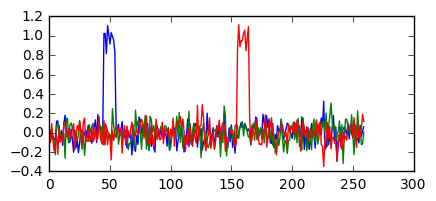

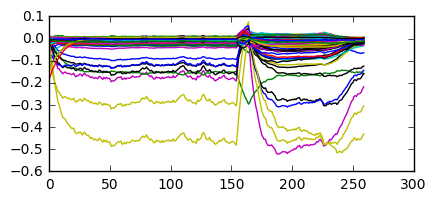

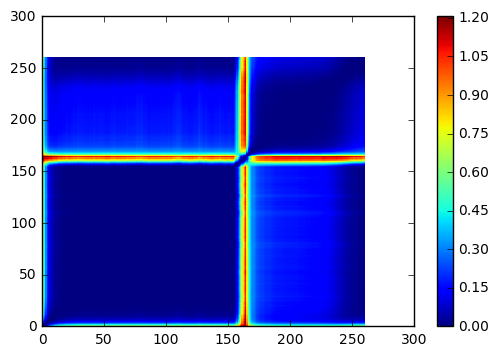

In [12]:
trial = 2

plt.figure(figsize=(4.7,2))
plt.plot(data[0][trial,:,:]);

plt.figure(figsize=(4.7,2))
plt.plot(s[:,trial,:]);

plt.figure()
plt.pcolormesh(1-np.corrcoef(s[:,trial,:]))
plt.colorbar()
# for ii in range(100):
#     plt.plot(data[0][ii,:,0],'b');
#     plt.plot(data[0][ii,:,1],'g');
#     plt.plot(data[0][ii,:,2],'r');
#     plt.plot(data[1][ii,:,:]);

/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: invalid value encountered in arccos


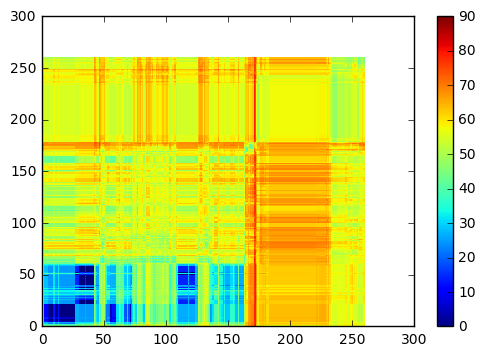

In [86]:
# masks = (np.mean(s,axis=1).T>0)
masks0 = s[:,3,:].T>0
masks1 = s[:,2,:].T>0

# W = np.random.randn(100,100)
# dale = np.eye(100)
# dale[:,50] *= -1
# W = np.abs(W).dot(dale)

# W = 1.1*W/np.max(np.abs(np.linalg.eig(W)[0]))

max_ev = np.zeros(data[0].shape[1])

# neg0 = []
# neg1 = []
leading0 = []
leading1 = []

for ii in range(data[0].shape[1]):
    evals0,evecs0 = np.linalg.eig(W*masks0[:,ii]-np.eye(100))
    evals1,evecs1 = np.linalg.eig(W*masks1[:,ii]-np.eye(100))
#     max_ev[ii] = np.max(evals.real)
#     neg0.append(evecs0[:,evals0<0])
#     neg1.append(evecs1[:,evals1<0])
    leading0.append(evecs0[:,np.argsort(np.abs(evals0.real))[:5]])
    leading1.append(evecs1[:,np.argsort(np.abs(evals1.real))[:5]])
    

xx = np.arange(0,data[0].shape[1],1)
pa = np.zeros([len(xx),len(xx)])

# basis = neg

for ii,pre in enumerate(xx):
    for jj,post in enumerate(xx):
        if leading0[pre].shape[1]*leading1[post].shape[1]>0:
            pas = principal_angle(leading0[pre],leading1[post])
            pa[ii,jj] = np.nanmean(pas)
        else:
            pa[ii,jj] = 0.
        
plt.pcolormesh(pa,vmin=0,vmax=90)
plt.colorbar()
plt.show()
        

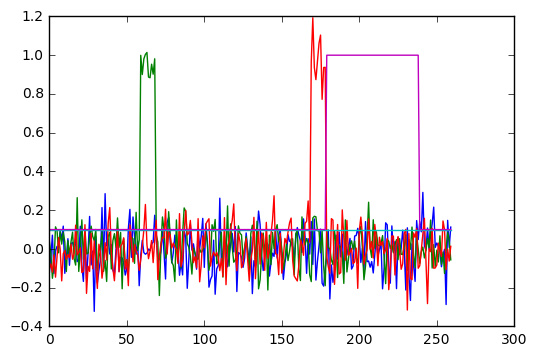

In [22]:
plt.plot(data[0][3,:,:])
plt.plot(data[1][3,:,:])

In [23]:
f = mt.state_tensor_decomposition(np.maximum(s,0),rank=6)

Using mxnet backend.


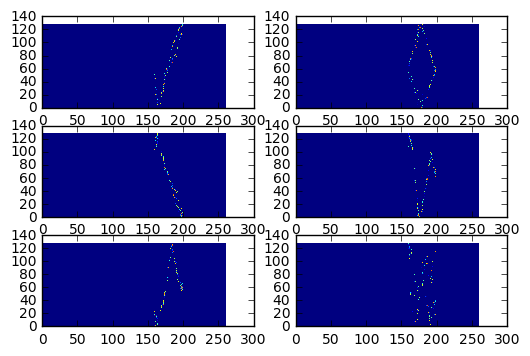

In [24]:
# plt.figure()
# plt.plot(f[0])

plt.figure()
for ii in range(6):
    plt.subplot(3,2,ii+1)
    plt.pcolormesh(np.maximum(s[:,np.argsort(f[1][:,ii]),0].T,0))
#     plt.pcolormesh(data[0][np.argsort(f[1][:,ii]),:,2])

plt.show()

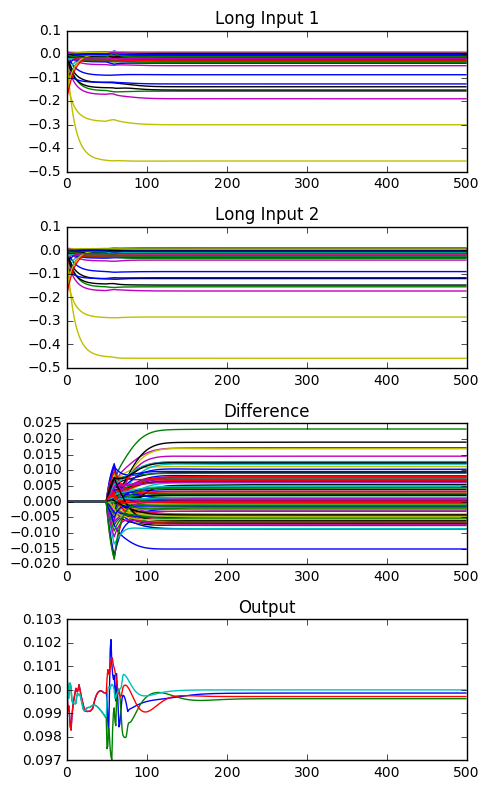

In [13]:
plt.figure(figsize=(5,8))

plt.subplot(4,1,1)
plt.plot(s1[:500,0,:]);
plt.title('Long Input 1')
plt.subplot(4,1,2)
plt.plot(s0[:500,0,:]);
plt.title('Long Input 2')
plt.subplot(4,1,3)
plt.plot(s0[:500,0,:] - s1[:500,0,:]);
plt.title('Difference')
plt.subplot(4,1,4)
plt.plot(out1[:500,0,:]);
plt.plot(out0[:500,0,:]);
plt.title('Output')

plt.tight_layout()
plt.show()

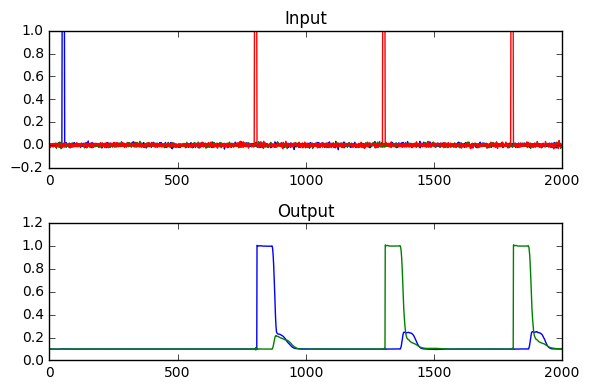

In [14]:
d = .01*np.random.randn(2000,3)
d[50:60,0] = 1.
# d[100:110,1] = 2.
# d[200:210,0] = 2.
# d[300:310,1] = 2.
d[800:810,2] = 1.
d[1300:1310,2] = 1.
d[1800:1810,2] = 1.

o_long,s_long = sim.run_trial(d,t_connectivity=False)

plt.subplot(2,1,1)
plt.plot(d)
plt.title('Input')

plt.subplot(2,1,2)
plt.plot(o_long[:,0,:]);
plt.title('Output')

plt.tight_layout()
plt.show()

In [15]:
s.shape

(260, 128, 100)

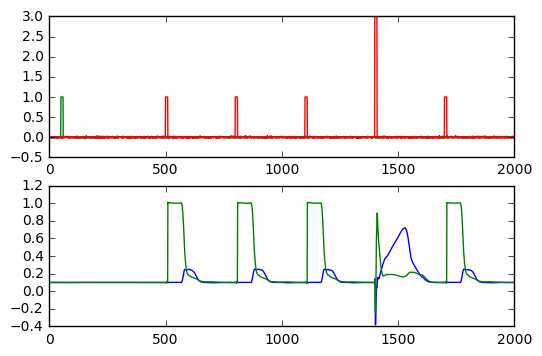

In [16]:
d = .01*np.random.randn(2000,3)
d[50:60,1] = 1.

d[500:510,2] = 1.
d[800:810,2] = 1.
d[1100:1110,2] = 1.
d[1400:1410,2] = 3.
d[1700:1710,2] = 1.


o_long,s_long = sim.run_trial(d,t_connectivity=False)

plt.subplot(2,1,1)
plt.plot(d)

plt.subplot(2,1,2)
plt.plot(o_long[:,0,:]);

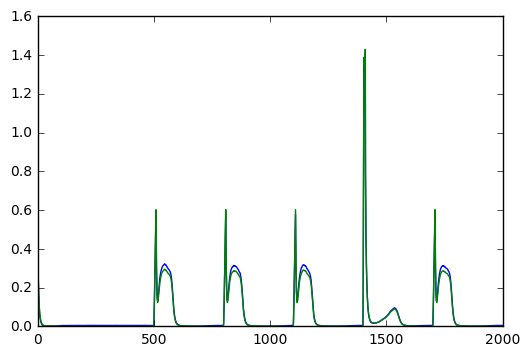

In [17]:
dist2fp0 = plot_dist_to_fixed(s_long,fps0[0]['fp'])
dist2fp1 = plot_dist_to_fixed(s_long,fps1[0]['fp'])

plt.cla()

plt.plot(dist2fp0)
plt.plot(dist2fp1)

In [18]:
n_steps = 2500
n_hidden = W.shape[0]
x = np.zeros([n_hidden,n_steps])

alpha = .1

fps_diff = fps0[-1]['fp'] - fps1[-1]['fp']

pulse10 = fps_diff/alpha
pulse01 = -fps_diff/alpha

mu = .0*np.random.randn(n_hidden,n_steps)

mu[:,500] = pulse10
mu[:,1000] = pulse01
mu[:,1500] = pulse10*.8



for ii in range(n_steps):
    x[:,ii] = (1-alpha)*x[:,ii-1] + alpha * (W.dot(np.maximum(x[:,ii-1],0))+brec + mu[:,ii])

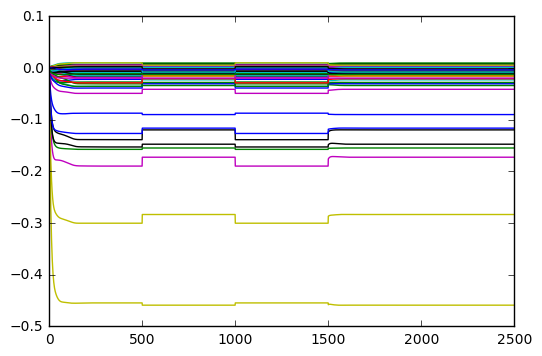

In [19]:
plt.plot(x.T);

(0, 0.03)

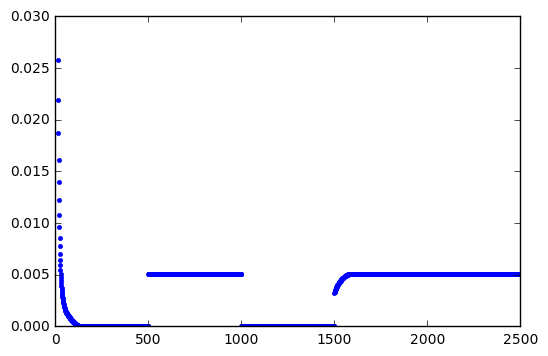

In [20]:
plot_dist_to_fixed(x.T,fps1[-1]['fp']);
plt.ylim([0,.03])
# plot_dist_to_fixed(x.T,s[0,0,:]);

(0, 0.015)

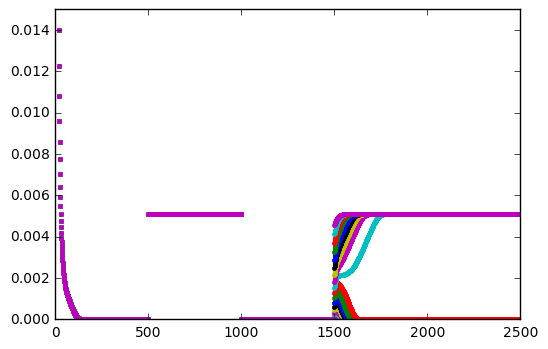

In [21]:
n_steps = 2500
n_hidden = W.shape[0]
x = np.zeros([n_hidden,n_steps])

fps_diff = fps0[-1]['fp'] - fps1[-1]['fp']

pulse10 = fps_diff/alpha
pulse01 = -fps_diff/alpha

mu = .0*np.random.randn(n_hidden,n_steps)

mu[:,500] = pulse10
mu[:,1000] = pulse01

for jj in np.arange(.05,1,.05):
    
    x = np.zeros([n_hidden,n_steps])
    
    mu[:,1500] = pulse10*jj

    alpha = .1

    for ii in range(n_steps):
        x[:,ii] = (1-alpha)*x[:,ii-1] + alpha * (W.dot(np.maximum(x[:,ii-1],0))+brec + mu[:,ii])
        
    plot_dist_to_fixed(x.T,fps1[0]['fp']);
    
plt.ylim([0,.015])

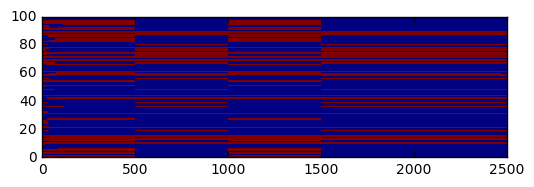

In [22]:
plt.subplot(2,1,1)
plt.pcolormesh(x>0);


In [29]:
masks = s[:,2,:].T>0

x_hat = np.zeros(masks.shape)

# plt.pcolormesh(masks)

for ii in range(masks.shape[1]):
    Weff = W*masks[:,ii]
    
    x_hat[:,ii] = np.linalg.inv(np.eye(100)-Weff).dot(brec)

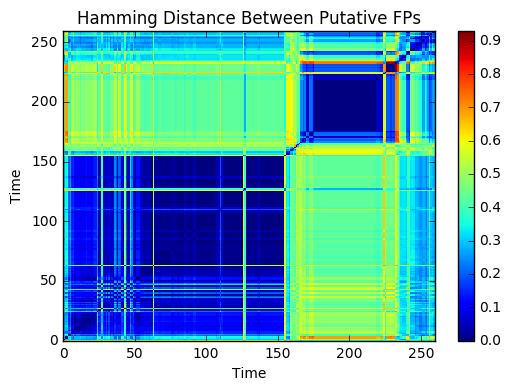

In [30]:
from scipy.spatial.distance import pdist, squareform

plt.pcolormesh(squareform(pdist(np.sign(x_hat[:,:]).T,metric='hamming'))) #,vmax=.3)
plt.colorbar()
plt.ylim([0,x_hat.shape[1]])
plt.xlim([0,x_hat.shape[1]])

plt.title('Hamming Distance Between Putative FPs')
plt.ylabel('Time')
plt.xlabel('Time')

plt.show()

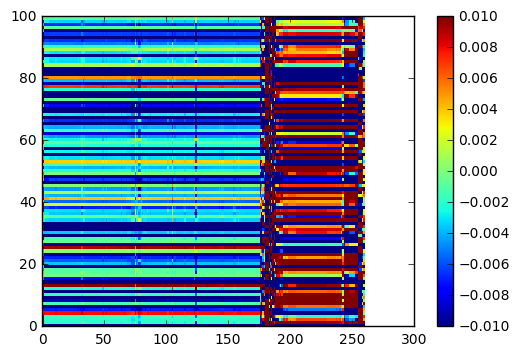

In [37]:
plt.pcolormesh(x_hat,vmax=.01,vmin=-.01)
plt.colorbar()
plt.show()

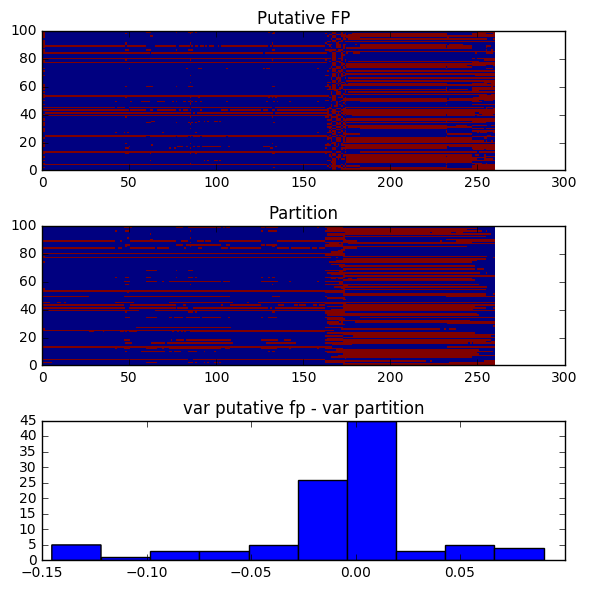

In [98]:
# print np.var(x_hat>0,axis=1)- np.var(masks,axis=1)
# print np.mean(np.var(masks,axis=1))

plt.figure(figsize=(6,6))

plt.subplot(3,1,1)
plt.pcolormesh(x_hat>0)
plt.title('Putative FP')

plt.subplot(3,1,2)
plt.pcolormesh(masks)
plt.title('Partition')

plt.subplot(3,1,3)
plt.hist(np.var(x_hat>0,axis=1)- np.var(masks,axis=1))
plt.title('var putative fp - var partition')

plt.tight_layout()
plt.show()

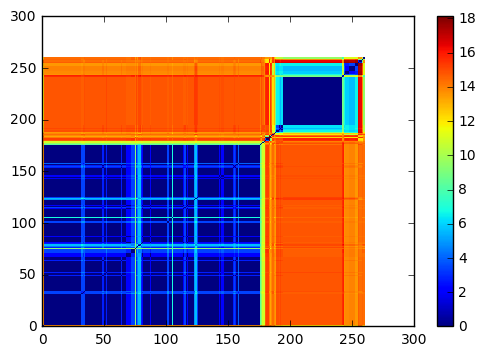

In [39]:
from scipy.spatial.distance import pdist, squareform

plt.pcolormesh(squareform(pdist(np.sign(x_hat[:,:]).T))) #,vmax=.3)
plt.colorbar()
plt.show()


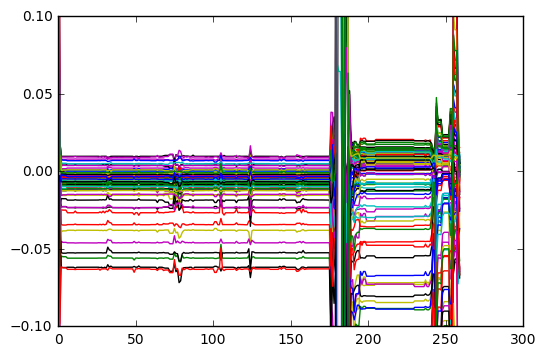

In [40]:
plt.plot(x_hat.T)
plt.ylim([-.1,.1])
plt.show()

In [41]:
x_hat.shape

(100, 260)

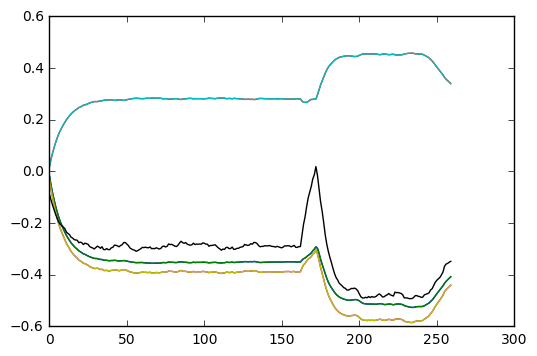

In [138]:
Weff = W*fps1[-1]['partition']

evals,evecs = np.linalg.eig(Weff-np.eye(100))

lead_evals = np.argsort(np.abs(evals.real))

plt.plot(s[:,2,:].dot(evecs[:,lead_evals[0:7]]));